In [1]:
pip install pandas numpy scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


Cross-validated Precision: 0.651
Cross-validated Accuracy: 0.747
Cross-validated Recall: 0.581


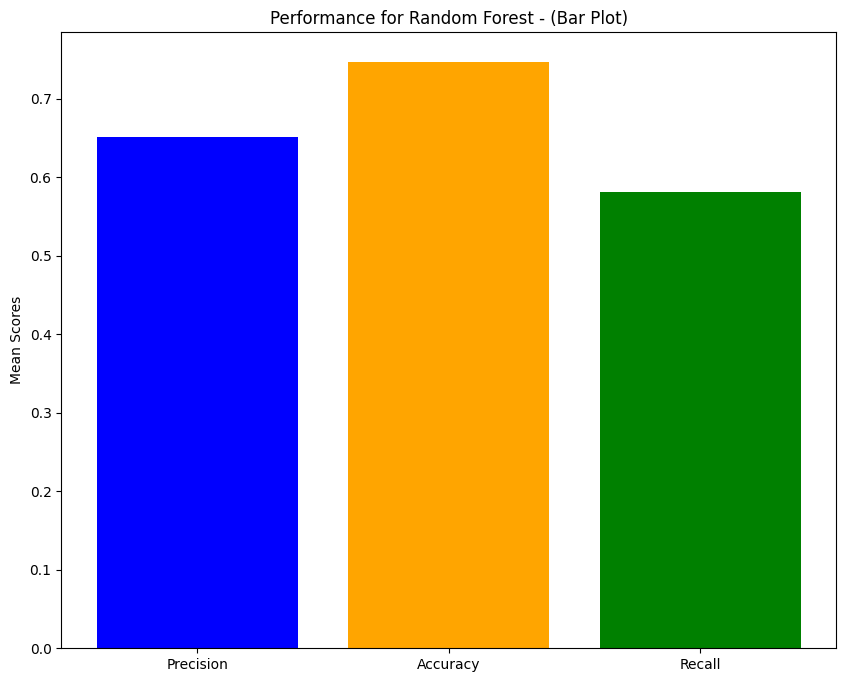

In [2]:
# Libarireis
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt


# finding optimum feature and threshold and splitting data to left and right
def splitting_lr(X, y):
    #initilization
    error_ = float('inf')
    split = None

    index = 0 # Starting from the first feature
    while index < X.shape[1]:  # Looping through for all features
        sorted_idx = np.argsort(X[:, index])
        X_sorted = X[sorted_idx]   # Sorting the features
        y_sorted = y[sorted_idx] # Sorting the target variable

        i = 1  # Start splitting from the second sample
        while i < X.shape[0]:  # Compare to number of samples
            if X_sorted[i][index] == X_sorted[i - 1][index] :    # Skiping equal values for not meeting identical splits
                i = i + 1
                continue

            left_y = y_sorted[:i]
            right_y = y_sorted[i:]

            
            # Calculating classification error for both the left and right splits
            classification_error_left = 1 - np.max(np.unique(left_y, return_counts=True)[1] / len(left_y))
            classification_error_right = 1 - np.max(np.unique(right_y, return_counts=True)[1] / len(right_y))
            error_split = (len(left_y) / X.shape[0]) * classification_error_left + (len(right_y) / X.shape[0]) * classification_error_right

            if error_split < error_:
                error_ = error_split
                threshold = X_sorted[i - 1][index]
    
                # initiliza left and right indices lists 
                
                indices_for_left_split = []
                indices_for_right_split = []

                
                for idx in range(X.shape[0]):
                    if X[idx, index] > threshold:       # Assigning indices according to threshold
                        indices_for_right_split.append(idx)
                    else:
                        indices_for_left_split.append(idx)

                # keeping the information od split
                split = {
                    'left': np.array(indices_for_left_split),
                    'right': np.array(indices_for_right_split),
                    'feature': index,
                    'threshold': threshold
                }
            i = i + 1  # go  to next index
        index = index + 1  # go to next feature

    return split # Return the best result for split

# this function for decision tree (recursively)
def decision_tree(X, y, maximum_depth=None, minimum_samples_for_split=2, current_depth=0):
    
    # Switch function for different cases in decision tree
    def switch(case):
        switch_dict = {
            "all_sample_same_class": lambda: y[0],  # when all samples in the same class, return the class
            "reached_maximum_depth": lambda: np.unique(y, return_counts=True)[0][np.argmax(np.unique(y, return_counts=True)[1])],  # when max depth reached
            "few_samples": lambda: np.unique(y, return_counts=True)[0][np.argmax(np.unique(y, return_counts=True)[1])],     # when too few samples
            "no_spliting ": lambda: np.unique(y, return_counts=True)[0][np.argmax(np.unique(y, return_counts=True)[1])], # when no split
            "default": lambda: split_tree() # Otherwise, split the tree recursively
        }
        return switch_dict.get(case, switch_dict["default"])()

    def split_tree():
        split = splitting_lr(X, y)
        left_tree = decision_tree(X[split['left']], y[split['left']], maximum_depth, minimum_samples_for_split, current_depth + 1)
        right_tree = decision_tree(X[split['right']], y[split['right']], maximum_depth, minimum_samples_for_split, current_depth + 1)
        return {'split': split, 'left': left_tree, 'right': right_tree}

    # termination conditions
    if len(set(y)) == 1:
        return switch("all_sample_same_class")

    if maximum_depth is not None and (current_depth == maximum_depth | current_depth > maximum_depth):
        return switch("reached_maximum_depth")

    if len(y) < minimum_samples_for_split:
        return switch("few_samples")

    split = splitting_lr(X, y)
    if not split:
        return switch("no_spliting")

    return switch("default")

# Function to predict (iy uses decision tree)
def predict_tree(X, tree):
    predictions = []  # Initialization an empty list
    
    for x in X:
        current_node = tree
        # Loop the tree until find a leaf node
        while isinstance(current_node, dict):  # While the current node is not a leaf node
            index = current_node['split']['feature'] # Getting the feature index 
            threshold = current_node['split']['threshold']  # Getting the threshold
            
            # ternary operator for node selection
            # left or right node according to the feature value
            current_node = current_node['left'] if x[index] <= threshold else current_node['right']
        
        predictions.append(current_node)  # Adding the leaf node value like prediction

    return np.array(predictions)

# Random forest (creating multiple decision trees)
def training_part_of_random_forest(X, y, number_of_estimators=100, maximum_depth=None, minimum_samples_split=2):
    trees = []
    for _ in range(number_of_estimators):  # Loop through to create number_of_estimators trees
        indices = np.random.choice(len(X), size=len(X), replace=True)
        tree = decision_tree(X[indices], y[indices], maximum_depth, minimum_samples_split)
        trees.append(tree)
    return trees

from collections import Counter

def predict_random_forest(X, trees):
    # Initialization an array in order to store votes
    votes = np.zeros((len(X), len(trees)), dtype=int)
    
    # Finding predictions for each tree
    for i, tree in enumerate(trees):
        votes[:, i] = predict_tree(X, tree)
    
    # Determining the common vote for each sample using Counter
    votes_list = []
    for sample_votes in votes:
        count = Counter(sample_votes)
        votes_list.append(count.most_common(1)[0][0])  
    
    return np.array(votes_list)

# Loading dataset
dataset = "C:\\Users\\AKDEMNB\\Downloads\\pima-indians-diabetes.csv"

columns = ['Pregnancy', 'Glucose', 'BloodPressure', 'Thickness', 'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Class']
data = pd.read_csv(dataset, names=columns)

X = data.drop('Class', axis=1).values
y = data['Class'].values

# k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
precisions = []
accuracies = []
recalls = []

for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]

    y_train = y[train_index]
    y_test = y[test_index]

    trees = training_part_of_random_forest(X_train, y_train, number_of_estimators=20, maximum_depth=20)
    y_pred = predict_random_forest(X_test, trees)

    precisions.append(precision_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Printing results
print(f"Cross-validated Precision: {np.mean(precisions):.3f}")
print(f"Cross-validated Accuracy: {np.mean(accuracies):.3f}")
print(f"Cross-validated Recall: {np.mean(recalls):.3f}")

# Plotting performance as a bar plot
mean_of_precisions = np.mean(precisions)
mean_of_accuracies = np.mean(accuracies)
mean_of_recalls = np.mean(recalls)

metrics = ['Precision', 'Accuracy', 'Recall']
mean_values = [mean_of_precisions, mean_of_accuracies, mean_of_recalls]

plt.figure(figsize=(10, 8))
plt.bar(metrics, mean_values, color=['blue', 'orange', 'green'])
plt.title('Performance for Random Forest - (Bar Plot)')
plt.ylabel('Mean Scores')
plt.show()
